In [1]:
import poppy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
poppy.__version__

'0.5.0'

In [2]:
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'

In [3]:
D = 2.
wavelen = 1e-6
ovsamp = 8

# No FPM (control case)
fftcoron_noFPM_osys = poppy.OpticalSystem(oversample=ovsamp)
fftcoron_noFPM_osys.addPupil( poppy.CircularAperture(radius=D/2) )
fftcoron_noFPM_osys.addImage()
fftcoron_noFPM_osys.addPupil( poppy.CircularAperture(radius=0.9*D/2) )
fftcoron_noFPM_osys.addDetector( pixelscale=0.025, fov_arcsec=4. )

# Classical Lyot FPM, spot radius ~ 4 lam/D
fftcoron_spotFPM_osys = poppy.OpticalSystem(oversample=ovsamp)
fftcoron_spotFPM_osys.addPupil( poppy.CircularAperture(radius=1.) )
fftcoron_spotFPM_osys.addImage( poppy.CircularOcculter(radius=0.4) ) 
fftcoron_spotFPM_osys.addPupil( poppy.CircularAperture(radius=0.9*D/2) )
fftcoron_spotFPM_osys.addDetector( pixelscale=0.05, fov_arcsec=4. )

# Annular diaphragm FPM, inner radius ~ 4 lam/D, outer rad ~ 16 lam/D
fftcoron_annFPM_osys = poppy.OpticalSystem(oversample=ovsamp)
fftcoron_annFPM_osys.addPupil( poppy.CircularAperture(radius=D/2) )
spot = poppy.CircularOcculter( radius=0.4  )
diaphragm = poppy.InverseTransmission( poppy.CircularOcculter( radius=1.6 ) )
annFPM = poppy.CompoundAnalyticOptic( opticslist = [diaphragm, spot] )
fftcoron_annFPM_osys.addImage( annFPM )
fftcoron_annFPM_osys.addPupil( poppy.CircularAperture(radius=0.9*D/2) )
fftcoron_annFPM_osys.addDetector( pixelscale=0.05, fov_arcsec=4. )

# Re-cast as MFT coronagraph with annular diaphragm FPM
matrixFTcoron_annFPM_osys = poppy.MatrixFTCoronagraph( fftcoron_annFPM_osys, occulter_box=diaphragm.uninverted_optic.radius_inner )

In [4]:
noFPM_fft_psf = fftcoron_noFPM_osys.calcPSF(wavelen, display_intermediates=False)

In [5]:
spotFPM_fft_psf = fftcoron_spotFPM_osys.calcPSF(wavelen, display_intermediates=False)

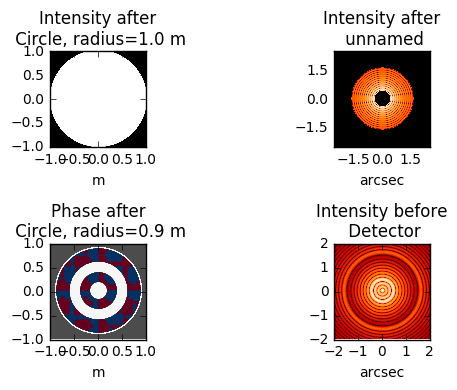

In [6]:
t0_fft = time.time()
annFPM_fft_psf, annFPM_fft_interm = fftcoron_annFPM_osys.calcPSF(wavelen, display_intermediates=True,\
                                                                 return_intermediates=True)
t1_fft = time.time()
plt.tight_layout()

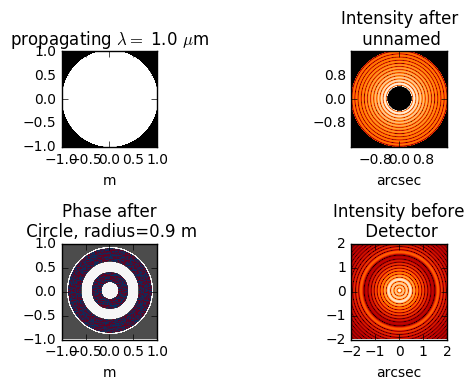

In [7]:
t0_mft = time.time()
annFPM_mft_psf, annFPM_mft_interm = matrixFTcoron_annFPM_osys.calcPSF(wavelen, display_intermediates=True,\
                                                                     return_intermediates=True)
t1_mft = time.time()
plt.tight_layout()

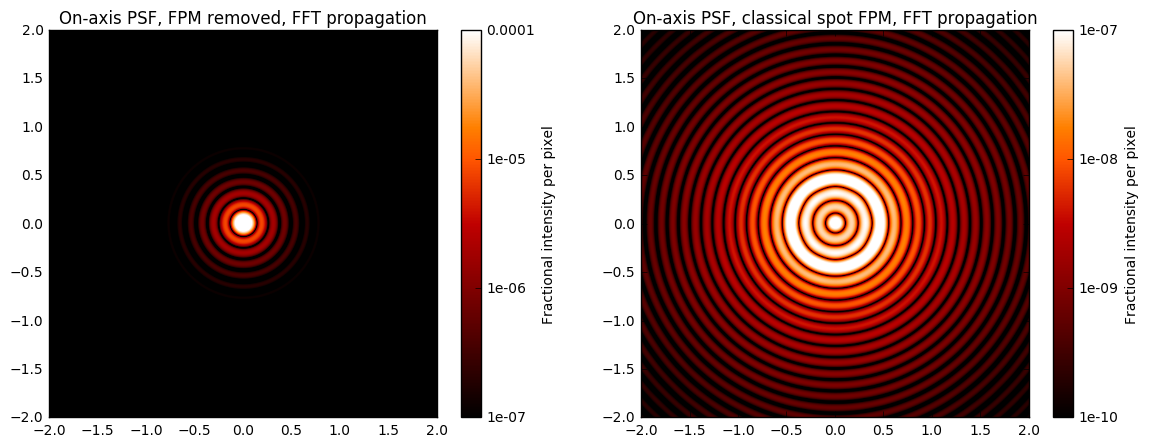

In [8]:
plt.figure(figsize=(14,5))
plt.subplot(121)
poppy.display_PSF(noFPM_fft_psf, vmax=1e-4, title='On-axis PSF, FPM removed, FFT propagation')
plt.subplot(122)
poppy.display_PSF(spotFPM_fft_psf, vmin=1e-10, vmax=1e-7, title='On-axis PSF, classical spot FPM, FFT propagation')

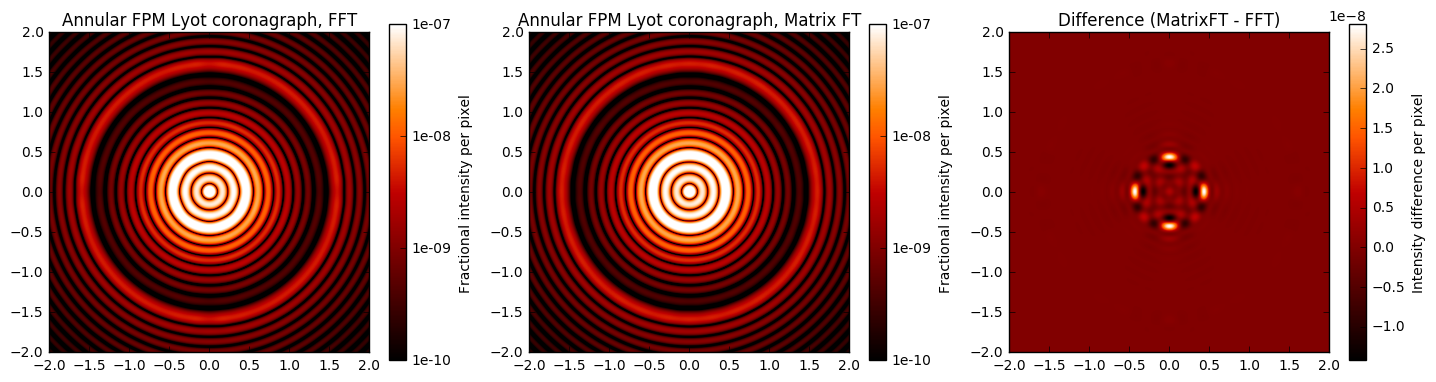

In [9]:
plt.figure(figsize=(16,3.5))
plt.subplots_adjust(left=0.10, right=0.95, bottom=0.02, top=0.98, wspace=0.2, hspace=None)
plt.subplot(131)
ax_fft, cbar_fft = poppy.display_PSF(annFPM_fft_psf, vmin=1e-10, vmax=1e-7, title='Annular FPM Lyot coronagraph, FFT',
                                     return_ax=True)
plt.subplot(132)
poppy.display_PSF(annFPM_mft_psf, vmin=1e-10, vmax=1e-7, title='Annular FPM Lyot coronagraph, Matrix FT')
plt.subplot(133)
diff_vmin = np.min(annFPM_mft_psf[0].data - annFPM_fft_psf[0].data)
diff_vmax = np.max(annFPM_mft_psf[0].data - annFPM_fft_psf[0].data)
poppy.display_PSF_difference(annFPM_mft_psf, annFPM_fft_psf, vmin=diff_vmin, vmax=diff_vmax, cmap='gist_heat')
plt.title('Difference (MatrixFT - FFT)')

In [10]:
import astropy.units as u
lamoD_asec = (wavelen*u.m/fftcoron_annFPM_osys.planes[0].pupil_diam * u.radian).to(u.arcsec)
print("System diffraction resolution element scale (lambda/D)  "+ str(np.round(lamoD_asec,4)))
print("Array width in first focal plane, FFT: %d" % annFPM_fft_interm[1].amplitude.shape[0])
print("Array width in first focal plane, MatrixFT: %d" % annFPM_mft_interm[1].amplitude.shape[0])
print("Array width in Lyot plane, FFT: %d" % annFPM_fft_interm[2].amplitude.shape[0])
print("Array width in Lyot plane, MatrixFT: %d" % annFPM_mft_interm[2].amplitude.shape[0])

System diffraction resolution element scale (lambda/D)  0.1031 arcsec
Array width in first focal plane, FFT: 8192
Array width in first focal plane, MatrixFT: 248
Array width in Lyot plane, FFT: 8192
Array width in Lyot plane, MatrixFT: 1024


In [11]:
SoS_res = np.sum( (annFPM_mft_psf[0].data - annFPM_fft_psf[0].data)**2 )
print("Maximum absolute value of difference between MatrixFT and FFT PSF intensity arrays: %g" % \
    np.max(np.abs(annFPM_mft_psf[0].data - annFPM_fft_psf[0].data)))
print("Root mean square of difference between MatrixFT and FFT PSF intensity arrays: %g" % \
    (np.sqrt(SoS_res/annFPM_mft_psf[0].data.shape[0]**2)))
print("Sum-of-squares difference between MatrixFT and FFT PSF intensity arrays: %g" % SoS_res)

Maximum absolute value of difference between MatrixFT and FFT PSF intensity arrays: 2.80469e-08
Root mean square of difference between MatrixFT and FFT PSF intensity arrays: 1.47103e-09
Sum-of-squares difference between MatrixFT and FFT PSF intensity arrays: 8.86347e-13


In [12]:
print("Elapsed time, FFT:  %.1f s" % (t1_fft-t0_fft))
print("Elapsed time, Matrix FT:  %.1f s" % (t1_mft-t0_mft))

Elapsed time, FFT:  95.2 s
Elapsed time, Matrix FT:  1.9 s
